In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [3]:
# Create the grid for the houses

def new_grid(n,m):
    '''
    Set up a new, empty grid
    '''
    return np.ones([n,m])

In [4]:
def even_houses(n,m,v):
    '''
    Set up a grid where all houses have the same inital value v. Every grid box is a house
    '''
    houses = v*new_grid(n,m)
    return houses

In [6]:
def plot_grid(grid):
    ''' 
    Plot a grid with yellow as high value and blue as low value
    '''
    img = plt.imshow(grid,cmap='inferno')
    return img

In [7]:
# Initialize affluence of householders as their own grid corresponding to which house they are in
def householders(n, m, a, p):
    '''
    Initialize affluence of householders as their own grid corresponding to which house they are in
    Inputs:
    a (array) the affluence amounts
    p (array) respective proportion of affluence amounts 
    '''
    affluence = new_grid(n,m)
    affluence = np.random.choice(a,size = (n,m), p=p)

    return affluence

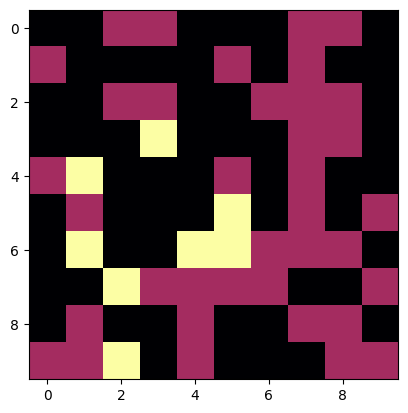

In [8]:
a = [1,0.5,0.1]
p = [0.1, 0.4, 0.5]

test = householders(10,10, a,p)

plot_grid(test)

In [9]:
# Check to see if we should move the householders and then move if needed
def delta(houses, affluence, x, y):
    '''
    Check to see if we should move the householders and then move if needed
    Inputs:
    x (array) index of one of the householders
    y (array) index of the other householders
    '''

    delta = (affluence[x] - houses[x])**2 + (affluence[y] - houses[y])**2 - (affluence[x] - houses[y])**2 - (affluence[y] - houses[x])**2

    # Swtich householders if necessary
    if delta > 0:
        x_old = x

        x = y
        y = x_old

In [10]:
# Calculate average prices depending on where you are in the grid

In [11]:
# Update all the values
def update_house_prices(houses, affluence, weight):
    '''
    Calculate Vt function and update the houses values
    '''
    # Figure out how to do the boundary houses

    for n in range(houses.shape[0]):
        for m in range(houses.shape[1]):
            houses[n,m] = affluence[n,m] + weight#*average function